<a href="https://colab.research.google.com/github/tingard/kaggle-humpback-whales/blob/master/humpback_whales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Humpback whale competition, on Kaggle

In [1]:
!pwd
!pip install kaggle
!pip install scikit-image --upgrade
!mkdir ~/.kaggle

/content
Requirement already up-to-date: scikit-image in /usr/local/lib/python3.6/dist-packages (0.14.2)
mkdir: cannot create directory ‘/root/.kaggle’: File exists


We need to authenticate kaggle - so set up the kaggle.json file (this is definitely not the most secure method)

In [0]:
import json
import getpass
import os
import pandas as pd
from IPython.display import Image
import skimage
import numpy as np

In [6]:
!ls ~/.kaggle
print('Has kaggle.json?', os.path.exists(os.path.expanduser('~/.kaggle/kaggle.json')))
if not os.path.exists(os.path.expanduser('~/.kaggle/kaggle.json')):
  key = getpass.getpass('Paste API key here')
  token = {"username":"tingard","key": key}

  with open(os.path.expanduser('~/.kaggle/kaggle.json'), 'w') as file:
      json.dump(token, file)

  !chmod 600 ~/.kaggle/kaggle.json

kaggle.json
Has kaggle.json? True


In [7]:
!mkdir train_images

mkdir: cannot create directory ‘train_images’: File exists


In [6]:
!kaggle competitions download -c humpback-whale-identification && unzip train.zip -d train_images > log.log

  0% 0.00/498k [00:00<?, ?B/s]
100% 498k/498k [00:00<00:00, 76.2MB/s]
  0% 0.00/594k [00:00<?, ?B/s]
100% 594k/594k [00:00<00:00, 35.8MB/s]
100% 1.34G/1.35G [00:10<00:00, 148MB/s]
100% 1.35G/1.35G [00:10<00:00, 132MB/s]
100% 4.15G/4.16G [01:51<00:00, 44.1MB/s]
100% 4.16G/4.16G [01:52<00:00, 39.8MB/s]


In [8]:
os.listdir('.')

['.config',
 'train.csv',
 'log.log',
 'test.zip',
 'train_images',
 'train.zip',
 'sample_submission.csv',
 'sample_data']

### We have our data!

Let's have a look at it

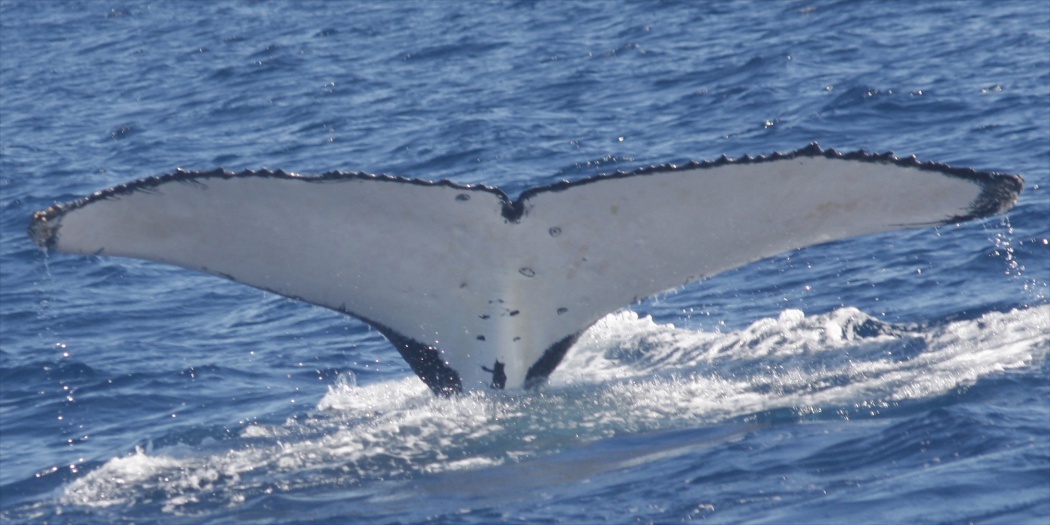

In [9]:
train_images = os.listdir('train_images')
Image(os.path.join('train_images', np.random.choice(train_images)))

In [10]:
sample_submission = pd.read_csv('sample_submission.csv')
training_set = pd.read_csv('train.csv')

ascending_groups = training_set.groupby('Id').count().sort_values(by='Image', ascending=False).head(10)
ascending_groups

,Image
Id,
new_whale,9664
w_23a388d,73
w_9b5109b,65
w_9c506f6,62
w_0369a5c,61
w_700ebb4,57
w_3de579a,54
w_564a34b,51
w_fd3e556,50


# Approach:

Provide two grey-scale pictures of a whale to a neural network. The network returns if they are the same whale or not (similar to how facial recognition works on phones I guess).

After some more research - One shot learning with Siamese networks?

# Architecture
Simple conv2D and pooling setup for now. Can experiment with transfer learning on something bigger at a later date

---
Import modules:

In [0]:
import tensorflow as tf

Define our model

In [13]:
whales_to_use = ascending_groups.iloc[1:20].index
whales_to_use

Index(['w_23a388d', 'w_9b5109b', 'w_9c506f6', 'w_0369a5c', 'w_700ebb4',
       'w_3de579a', 'w_564a34b', 'w_fd3e556', 'w_88e4537'],
      dtype='object', name='Id')

In [0]:
mask = np.isin(training_set['Id'].values, whales_to_use)
training_set_filtered = training_set[mask]

In [15]:
training_set_filtered.shape

(522, 2)

Credit: https://sorenbouma.github.io/blog/oneshot/

We'll put our data into a quicker-to-manage format:

In [0]:
!mkdir train_whales

In [18]:
import os
from IPython.display import Image as ipy_Image
from PIL import Image
import numpy as np
import pandas as pd
from skimage import transform, color, img_as_float
np.random.seed(0)

training_frame = pd.read_csv('./train.csv')
training_frame_count = (
    training_frame.groupby('Id')
                  .count()
                  .sort_values(by='Image', ascending=False)
)

training_frame_count.head()
for whale in training_frame_count.index.values[1:30]:
    print('Working on whale', whale)
    images_of_whale = training_frame[training_frame['Id'] == whale].values[:, 0]
    file_locations = [
        os.path.join('train_images', f)
        for f in images_of_whale
    ]

    whale_images = np.zeros((len(file_locations), 128, 128))
    for i, f in enumerate(file_locations):
        img_obj = Image.open(os.path.abspath(f))
        im = img_as_float(np.array(img_obj))
        grey = color.rgb2gray(im)
        whale_images[i] = transform.resize(
            grey, (128, 128),
            order=1, mode='constant', anti_aliasing=True
        )
    np.save(os.path.join('train_whales', whale), whale_images)


Working on whale w_23a388d
Working on whale w_9b5109b
Working on whale w_9c506f6
Working on whale w_0369a5c
Working on whale w_700ebb4
Working on whale w_3de579a
Working on whale w_564a34b
Working on whale w_fd3e556
Working on whale w_88e4537
Working on whale w_2b069ba
Working on whale w_d405854
Working on whale w_789c969
Working on whale w_f0fe284
Working on whale w_5e8e218
Working on whale w_778e474
Working on whale w_343f088
Working on whale w_5a2634c
Working on whale w_a9304b9
Working on whale w_60ce6fc


Define our data loader:

In [0]:
import os
import numpy as np


class HWSiameseLoader:
    def __init__(self):
        self.whales = {}
        for whale_file in os.listdir('train_whales'):
            whale_name = whale_file.split('.')[0]
            self.whales[whale_name] = np.load(
                os.path.join('train_whales', whale_file)
            )
        self.whale_keys = list(self.whales.keys())

    def get_batch(self, n, fraction_same=0.4):
        n_same = int(fraction_same * n)

        k1 = np.random.choice(len(self.whale_keys), n)
        k2 = np.concatenate((
            k1[:n_same],
            np.random.choice(len(self.whale_keys), n - n_same)
        ))

        whale1 = [self.whale_keys[i] for i in k1]
        whale2 = [self.whale_keys[i] for i in k2]

        indices1 = [np.random.randint(len(self.whales[w])) for w in whale1]
        indices2 = [np.random.randint(len(self.whales[w])) for w in whale2]

        y = (k1 == k2).astype(int)

        L = np.array([self.whales[w][i] for w, i in zip(whale1, indices1)])
        R = np.array([self.whales[w][i] for w, i in zip(whale2, indices2)])
        stacked = np.hstack((
            L.reshape(-1, 1, 128, 128, 1),
            R.reshape(-1, 1, 128, 128, 1),
        ))
        return [stacked[:, 0], stacked[:, 1]], y

    def make_oneshot_task(self, N):
        # make N pairs of images, the zeroth pair being of the same class and
        # all others being different classes
        max_N = len(self.whale_keys)
        k = np.random.choice(max_N, min(N, max_N), replace=False)
        whales = [self.whale_keys[i] for i in k]

        indices1 = [np.random.randint(len(self.whales[whales[0]])) for w in whales]
        indices2 = [np.random.randint(len(self.whales[w])) for w in whales]

        L = np.array([self.whales[whales[0]][i] for i in indices1])
        R = np.array([self.whales[w][i] for w, i in zip(whales, indices2)])
        stacked = np.hstack((
            L.reshape(-1, 1, 128, 128, 1),
            R.reshape(-1, 1, 128, 128, 1),
        ))
        y = (k == k[0]).astype(int)
        return [stacked[:, 0], stacked[:, 1]], y
       
    def test_oneshot(self, model, N, k):
        # Test average N way oneshot learning accuracy of a siamese neural net
        # over k one-shot tasks
        n_correct = 0
        for i in range(k):
            inputs, targets = self.make_oneshot_task(N)
            probs = model.predict(inputs)
            if np.argmax(probs) == 0:
                n_correct += 1
        percent_correct = (100.0 * n_correct / k)
        return percent_correct


loader = HWSiameseLoader()

And our model:

In [20]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D
from tensorflow.keras.layers import Lambda, Subtract
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam


input_shape = (128, 128, 1)
left_input = Input(input_shape)
right_input = Input(input_shape)

initializer_kwargs = {
    'kernel_initializer': 'random_normal',
    'bias_initializer': 'random_normal'
}

# build convnet to use in each siamese 'leg'
convnet = Sequential([
    Conv2D(64, (10, 10), activation='relu', input_shape=input_shape,
           kernel_initializer='random_normal', kernel_regularizer=l2(2e-4)),
    MaxPooling2D(),
    Conv2D(128, (7, 7), activation='relu', kernel_regularizer=l2(2e-4),
           **initializer_kwargs),
    MaxPooling2D(),
    Conv2D(128, (4, 4), activation='relu', kernel_regularizer=l2(2e-4),
           **initializer_kwargs),
    MaxPooling2D(),
    Conv2D(256, (4, 4), activation='relu', kernel_regularizer=l2(2e-4),
           **initializer_kwargs),
    Flatten(),
    Dense(1024, activation="sigmoid", kernel_regularizer=l2(1e-3),
          **initializer_kwargs),
])

# encode each of the two inputs into a vector with the convnet
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)

# merge two encoded inputs with the l1 distance between them
subtracted = Subtract()([encoded_l, encoded_r])

both = Lambda(lambda x: K.abs(x))(subtracted)

prediction = Dense(1, activation='sigmoid',
                   bias_initializer='random_normal')(both)

siamese_net = Model(inputs=[left_input, right_input], outputs=prediction)

# optimizer = SGD(0.0004,momentum=0.6,nesterov=True,decay=0.0003)

optimizer = Adam(0.00006)

# TODO: get layerwise learning rates and momentum annealing scheme described in
# paperworking
siamese_net.compile(loss="binary_crossentropy", optimizer=optimizer)

print('Param count:', siamese_net.count_params())


Param count: 18005057


And then do some training!!

In [66]:
import tensorflow as tf

loader = HWSiameseLoader()

evaluate_every = 500
loss_every=300
batch_size = 32
N_way = 15
n_val = 550
# siamese_net.load_weights("PATH")
# best = 76.0


for i in range(5000):
    (inputs, targets) = loader.get_batch(batch_size)
    loss = siamese_net.train_on_batch(inputs, targets)
    if i % evaluate_every == 0:
        val_acc = loader.test_oneshot(siamese_net, N_way, n_val)
        print('Accuracy: {:.2f}%'.format(val_acc))
#         if val_acc >= best:
#             print("saving")
#             siamese_net.save('PATH')
#             best = val_acc

    if i % loss_every == 0:
        print("iteration {}, training loss: {:.2f},".format(i, loss))


Accuracy: 38.91%
iteration 0, training loss: 1.17,
iteration 300, training loss: 1.04,
Accuracy: 58.73%
iteration 600, training loss: 0.87,


KeyboardInterrupt: ignored